In [8]:
import os
import math

import torch
import gpytorch

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import sklearn.gaussian_process as gp
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def filterinitialset (filename, headername = "vibrational level v\Temperature(K)",  \
    factor = 1.0, normalize = False):

    dfin = pd.read_excel(filename)

    #print(dfin)
    
    dfdict = {}
    
    tempvalues = list(dfin.columns[1:])
    vibvalues = list(dfin[headername].values)

    min = float("inf")
    max = float("-inf")
    for c in dfin.columns:
        dfdict[c] = []
        if c == headername:
            dfdict[c] = list(dfin[c].values)
        else:
            for v in dfin[c].values:
                val = factor*v
                if val > max:
                    max = val
                if val < min:
                    min = val

    for c in dfin.columns:
        if c != headername:
            for v in dfin[c].values:
                val = factor*v
                valp = (val - min) / (max - min)
                if normalize:
                    dfdict[c].append(valp)
                else:
                    dfdict[c].append(val)

    df = pd.DataFrame.from_dict(dfdict)

    return df, vibvalues, tempvalues

##############################################################################

def plotfull3dcurve (df, vib_values, temp_values):

    y = []
    x = []
    for t in temp_values:
        for idx in range(len(vib_values)):
            x.append([float(t), float(vib_values[idx])])
            y.append(df[t].values[idx])

    X = np.array(x)
    Y = np.array(y)

    xdim = len(temp_values)
    ydim = len(vib_values)

    Xp = np.zeros((xdim, ydim), dtype=float)
    Yp = np.zeros((xdim, ydim), dtype=float)
    Zp = np.zeros((xdim, ydim), dtype=float)
    for xidx in range(xdim):
        t = temp_values[xidx]
        for yidx in range(ydim):
            v =  vib_values[yidx]
            Xp[xidx, yidx] = float(t)
            Yp[xidx, yidx] = float(v)
            Zp[xidx, yidx] = df[t].values[yidx]

    #fig = plt.figure(figsize=(10,8))
    fig = plt.figure(figsize=plt.figaspect(2.))
    plt.gcf().set_size_inches(40, 30)
    ax = fig.add_subplot(2,1,1, projection='3d')
    surf = ax.plot_surface(Xp, Yp, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
    plt.show()

##########################################################################################################3

# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

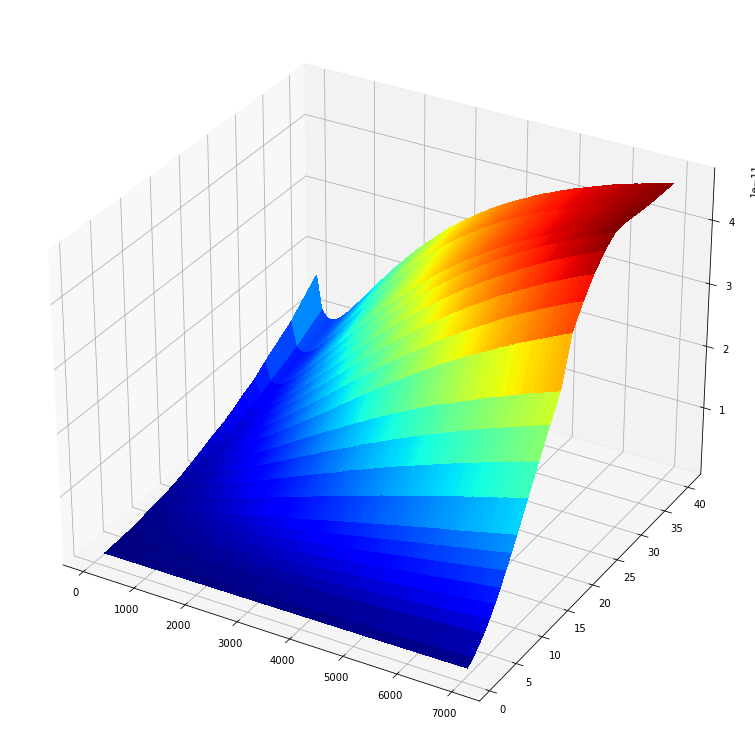

In [10]:
filename = "N2N2_dataset.xls"
df, vib_values , temp_values = filterinitialset (filename)
plotfull3dcurve (df, vib_values, temp_values)

In [15]:
def fitusinggpt (train_x, train_y, minx, maxx):
         # initialize likelihood and model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        model = ExactGPModel(train_x, train_y, likelihood)

        smoke_test = ('CI' in os.environ)
        training_iter = 2 if smoke_test else 10000
    
        # Find optimal model hyperparameters
        model.train()
        likelihood.train()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
                ))
            optimizer.step()

        # Get into evaluation (predictive posterior) mode
        model.eval()
        likelihood.eval()

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            test_x = torch.linspace(minx, maxx, 150, dtype=torch.float64)
            print("Test points: ", test_x)
            #print(test_x.shape, type(test_x))
            #print(type(model))
            observed_pred = likelihood(model(test_x))

        with torch.no_grad():
            # Initialize plot
            f, ax = plt.subplots(1, 1, figsize=(4, 3))

            # Get upper and lower confidence bounds
            lower, upper = observed_pred.confidence_region()
            # Plot training data as black stars
            ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
            # Plot predictive means as blue line
            ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
            # Shade between the lower and upper confidence bounds
            ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
            # ax.set_ylim([-3, 3])
            ax.legend(['Observed Data', 'Mean', 'Confidence'])
            plt.gcf().set_size_inches(15, 10)
            plt.show()

In [63]:
def fitusingscikitl (in_train_x, in_train_y, minx, maxx):

    train_x = in_train_x.numpy().reshape(-1, 1)
    train_y = in_train_y.numpy()

    #rom sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

    #kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1)

    #kernel=1**2 + Matern(length_scale=2, nu=1.5) + WhiteKernel(noise_level=1)
    #kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * \
    #     gp.kernels.RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))

    kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.RBF( length_scale_bounds=(1e-2, 1e5))
    #kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.RBF([5,5], (1e-2, 1e2))
    #kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * \
    #    gp.kernels.RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1e3))

    #l = 0.1
    #sigma_f = 2
    #kernel = gp.kernels.ConstantKernel(constant_value=sigma_f,constant_value_bounds=(1e-3, 1e3)) \
    #            * gp.kernels.RBF(length_scale=l, length_scale_bounds=(1e-3, 1e3))
    # *  gp.kernels.ExpSineSquared(length_scale=1, periodicity=2)

    #kernel = gp.kernels.ConstantKernel(1.0, (1e-3, 1e3)) * gp.kernels.PairwiseKernel(metric='rbf')
    #maternParams = {'length_scale': 1.0, 'nu': 1.5}
    #kernel = gp.kernels.Matern(**maternParams)
    model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, \
        normalize_y=False)
    print("Start training ")
    #model = RandomForestRegressor()
    model.fit(train_x, train_y)
    print("Done ")
    print(model.kernel)

    test_x = torch.linspace(minx, maxx, 150, dtype=torch.float64).numpy().reshape(-1, 1)

    y_pred, std = model.predict(test_x, return_std=True)

    for idx in range(len(y_pred)):
        print("%10.5e %10.5e"%(y_pred[idx], std[idx]))

    plt.scatter(train_x, train_y, label="True values")
    #plt.plot(test_x, y_pred, label="Predicted values")
    plt.errorbar(test_x, y_pred, std, marker='s', mfc='red', \
         mec='green', label="Predicted values")
    plt.xlabel("T")
    plt.ylabel("Rate")

    plt.gcf().set_size_inches(15, 10)
    plt.show()

V = 20
Xval range:  tensor(100., dtype=torch.float64) tensor(7000., dtype=torch.float64)
Yval range:  tensor(-31.8441, dtype=torch.float64) tensor(-28.6638, dtype=torch.float64)
Start training 


/home/redo/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Done 
1**2 * RBF(length_scale=1)
-3.16374e+01 1.00008e-05
-3.18193e+01 1.65902e-02
-3.18471e+01 1.86375e-03
-3.18114e+01 4.21296e-03
-3.17512e+01 1.21794e-03
-3.16800e+01 1.48747e-03
-3.16043e+01 7.88917e-04
-3.15300e+01 6.14725e-04
-3.14596e+01 5.39661e-04
-3.13923e+01 2.64885e-04
-3.13270e+01 3.87524e-04
-3.12645e+01 1.01640e-04
-3.12063e+01 2.87890e-04
-3.11521e+01 1.86934e-05
-3.10999e+01 2.17932e-04
-3.10482e+01 3.38693e-05
-3.09976e+01 1.65568e-04
-3.09490e+01 6.16009e-05
-3.09024e+01 1.24140e-04
-3.08570e+01 7.82433e-05
-3.08123e+01 8.98727e-05
-3.07686e+01 8.74146e-05
-3.07263e+01 6.06420e-05
-3.06853e+01 9.11618e-05
-3.06454e+01 3.54350e-05
-3.06066e+01 9.06406e-05
-3.05690e+01 1.50308e-05
-3.05324e+01 8.65588e-05
-3.04965e+01 1.33120e-05
-3.04615e+01 7.94270e-05
-3.04275e+01 2.78985e-05
-3.03942e+01 6.96898e-05
-3.03616e+01 4.16854e-05
-3.03302e+01 5.78117e-05
-3.03004e+01 5.28384e-05
-3.02717e+01 4.43308e-05
-3.02431e+01 6.09431e-05
-3.02144e+01 2.99635e-05
-3.01868e+01 6.57

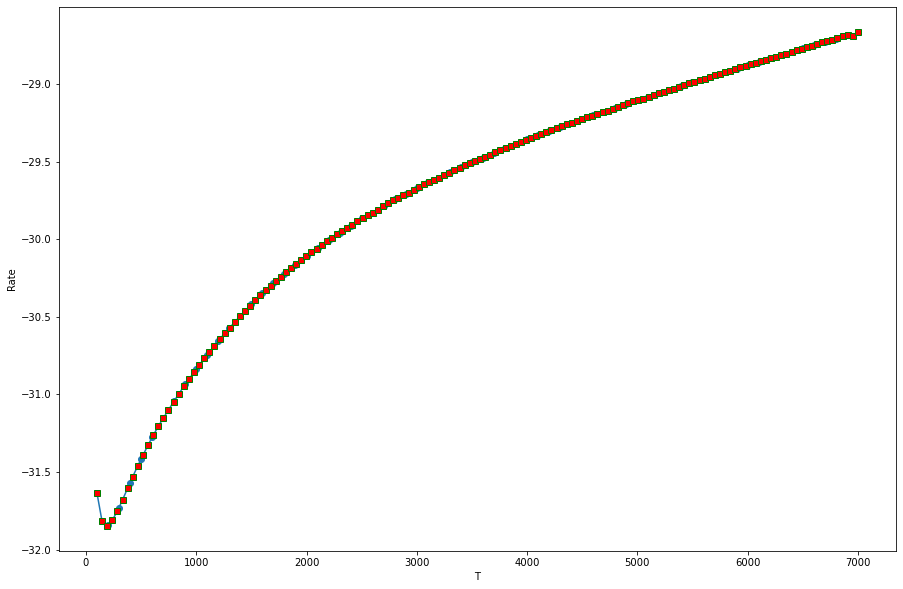

In [64]:
usescikt = True

train_x = torch.linspace(0, 1, len(temp_values), dtype=torch.float64)
train_y = torch.linspace(0, 1, len(temp_values), dtype=torch.float64)

for vibidx, selectedvib in enumerate(vib_values[13:14]):

    for idx, t in enumerate(temp_values):
        train_x[idx] = t
        
        yval = df[t].values[vibidx]
        yval = math.log(yval)
        train_y[idx] = yval

    print("V = " + str(selectedvib))
    minx = torch.min(train_x)
    maxx = torch.max(train_x)
    print("Xval range: ", minx, maxx)

    miny = torch.min(train_y)
    maxy = torch.max(train_y)
    print("Yval range: ", miny, maxy)
    
    #plt.title("V = " + str(selectedvib))
    #plt.scatter(train_x.numpy(), train_y.numpy())
    #plt.plot(train_x.numpy(), train_y.numpy())
    #plt.gcf().set_size_inches(15, 10)
    #plt.show()

    if usescikt:
        fitusingscikitl (train_x, train_y, minx, maxx)
    else:
        fitusinggpt (train_x, train_y, minx, maxx)
   